In [78]:
import cv2
import os
import pandas as pd
import numpy as np
import keras, tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from sklearn.model_selection import train_test_split



In [3]:
def extract(img, smaller):
        
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    if(smaller):
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

        # Applying dilation on the threshold image
        dilation = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, rect_kernel, iterations = 1)
        # dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    else:
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                    cv2.CHAIN_APPROX_NONE)

    return contours

In [62]:
def boundingbox(img_path, model):
    img = cv2.imread(img_path)
    contours = extract(img, False)

    sum = 0
    y_pred = []
    boxes = []
    im = img.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
        # Cropping the text block
        cropped = img[y:y + h, x:x + w]

        # extract each alphabet from each block
        contours2 = extract(cropped, True)
        
        for i in contours2:
            # count alphabets 
            sum += 1

            x2, y2, w2, h2 = cv2.boundingRect(i)
            
            cropped2 = img[y+y2: y+y2+h2, x+x2: x+x2+w2]
            
            boxes.append([x+x2, y+y2, x+x2 + w2, y+y2 + h2]) 

            cropped2 = cv2.resize(cropped2, (64,64))
            
            plt.imshow(cropped2)
            cropped2 = cropped2.reshape((1, 64, 64, 3))

            y_pred.append(model.predict(cropped2))


    y_pred = np.array(y_pred)
    return sum, y_pred, boxes, im


In [175]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block 3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout
model.add(Dense(62, activation='softmax'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_42 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 conv2d_123 (Conv2D)         (None, 32, 32, 32)      

In [144]:
# each classes(62 classes) has 55 images 
model_training_csv = os.path.join(os.getcwd(), 'alphabets/english.csv')
model_image_training = os.path.join(os.getcwd(), 'alphabets')

# make dataframe for training model 
model_training_df = pd.read_csv(model_training_csv)
# add columns of image
model_training_df['img'] = ''
# get image for each image name
for i in range(len(model_training_df)):
    img_path = os.path.join(model_image_training, model_training_df.at[i, 'image'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))

    model_training_df.at[i, 'img'] = img
# get all class names
class_names = model_training_df.label.unique()

# split each class equaly
x_train, y_train, x_test, y_test = [], [], [], []
temp = []
for name in class_names:
    split = model_training_df[model_training_df.label == name]
    X = split['img']
    Y = split['label']
    Y = [np.where(class_names == label)[0] for label in Y]

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.7)

    x_train.extend(X_train)
    y_train.extend(Y_train)
    x_test.extend(X_test)
    y_test.extend(Y_test)


# shuffle order of train and test data
temp_x_train, temp_y_train, temp_x_test, temp_y_test = [], [], [], []

train_rand_order = np.arange(len(x_train))
test_rand_order = np.arange(len(x_test))
np.random.shuffle(train_rand_order)
np.random.shuffle(test_rand_order)
for i in train_rand_order:
    temp_x_train.append(x_train[i])
    temp_y_train.append(y_train[i])

for j in test_rand_order:
    temp_x_test.append(x_test[j])
    temp_y_test.append(y_test[j])    

x_train = np.array(temp_x_train, dtype=np.float32)
x_test = np.array(temp_x_test, dtype=np.float32)
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)


# one-hot-encoded the label
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [176]:
batch_size = 32

# initiate RMSprop optimizer
# Using M1 mac
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=25,
                        validation_data=(x_test, y_test),
                        shuffle=True)


Epoch 1/25
74/74 [==============================] - 9s 120ms/step - loss: 4.3510 - accuracy: 0.0195 - val_loss: 4.1176 - val_accuracy: 0.0199
Epoch 2/25
74/74 [==============================] - 10s 138ms/step - loss: 4.1366 - accuracy: 0.0221 - val_loss: 4.0744 - val_accuracy: 0.0474
Epoch 3/25
74/74 [==============================] - 10s 139ms/step - loss: 4.0301 - accuracy: 0.0433 - val_loss: 3.8739 - val_accuracy: 0.0503
Epoch 4/25
74/74 [==============================] - 10s 140ms/step - loss: 3.9109 - accuracy: 0.0586 - val_loss: 3.6853 - val_accuracy: 0.1167
Epoch 5/25
74/74 [==============================] - 10s 142ms/step - loss: 3.7475 - accuracy: 0.0789 - val_loss: 3.4083 - val_accuracy: 0.1679
Epoch 6/25
74/74 [==============================] - 11s 143ms/step - loss: 3.5535 - accuracy: 0.1142 - val_loss: 3.2779 - val_accuracy: 0.2097
Epoch 7/25
74/74 [==============================] - 11s 146ms/step - loss: 3.3582 - accuracy: 0.1515 - val_loss: 3.0517 - val_accuracy: 0.2505


TEST_37868.jpg
1/1 [==============================] - 0s 20ms/step


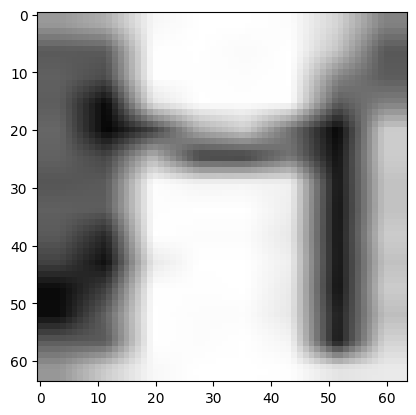

In [177]:
train_img_path = os.path.join(os.getcwd(), "archive/train_v2/train")
test_img_path = os.path.join(os.getcwd(), "archive/test_v2/test")

train_csv_path = os.path.join(os.getcwd(), "archive/written_name_train_v2.csv")
test_csv_path = os.path.join(os.getcwd(), "archive/written_name_test_v2.csv")



df = pd.read_csv(test_csv_path)
cnt = 0
im = 0
boxes = []

# for i in range (df.shape[0]):
for i in range (37867,37868):
    print(df['FILENAME'][i])
    img_name = os.path.join(test_img_path, df['FILENAME'][i])
    num_of_char, y_pred, boxes, img = boundingbox(img_name, model)
    # if num_of_char == len(str(df['IDENTITY'][i])):
    #     cnt += 1
    im = img
    cnt = num_of_char

In [178]:
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)
print(cnt)

wMQM
4


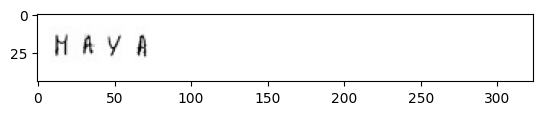

In [75]:
plt.imshow(im)

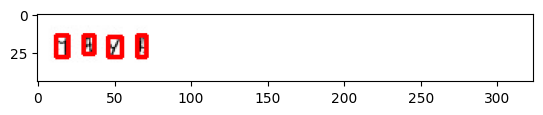

In [76]:
# save resulting image
for x1, y1, x2, y2 in boxes:
    rect = cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(im)